In [416]:
import pandas as pd
import cobra
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Say, "the default sans-serif font is COMIC SANS"
#matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12


In [417]:
deltaG = pd.read_csv('../assets/deltaG.iJO1366.eQuilibiatorAPI.pH7p4.298,15T.IS0,25M.csv')
metc = pd.read_csv('../assets/metabolite_concs.csv')

In [418]:
mets = pd.read_csv('../assets/metabolite_abundances/ecoli_met_concs_Park_NatChemBio_2016.csv')

,met,conc,conc_lb,conc_ub
0,10fthf[c],0.047379,0.0,0.1
1,12dgr120[c],0.028821,0.0,0.1
2,12dgr120[p],0.047379,0.0,0.1
3,12dgr140[c],0.008465,0.0,0.1
4,12dgr140[p],0.047379,0.0,0.1
...,...,...,...,...
1663,xylu-L[e],0.000688,0.0,0.1
1664,xylu-L[p],0.000367,0.0,0.1
1665,zn2[c],0.047379,0.0,0.1
1666,zn2[e],0.047379,0.0,0.1


In [254]:
metc = mets.copy()

In [10]:
model = cobra.io.read_sbml_model('../assets/iJO1366.xml')

Academic license - for non-commercial use only - expires 2022-08-19
Using license file /Users/joshuagoldford/gurobi.lic


In [12]:
rxns = pd.read_csv('../assets/EC_1.X.1.X.Unique_NAD(P)_Coupled.GeneSet.Thermo.csv')

In [255]:
computable = []
for idx,row in rxns.iterrows():
    mets_r = [x.id for x in model.reactions.get_by_id(row.reaction).metabolites]
    mets_r = [x for x in mets_r if x  not in ['h_c','h2o_c','h_p','h2o_p','h_e','h2o_e']]
    mets_c_r = metc[metc.met_id.isin(mets_r)].met_id.tolist()
    if len(mets_c_r) == len(mets_r):
        computable.append(True)
    else:
        computable.append(False)
rxns['computable'] = computable     

AttributeError: 'DataFrame' object has no attribute 'met_id'

In [211]:
rxns_c = rxns[rxns['computable']]
rxns_c

,reaction,gene,gene_name,deltaG_prime_m,deltaG_prime_m (error),computable
3,AKGDH,b0116,lpd,-28.188154,3.884974,True
30,G3PD2,b3608,gpsA,23.216165,0.805351,True
40,GLUSy,b3213,gltD,-48.317424,0.943672,True
46,GTHOr,b3500,gor,-30.254274,0.783942,True
48,HISTD,b2020,hisD,-15.870606,2.241588,True
65,ME1,b1479,maeA,-4.984909,3.118329,True
66,ME2,b2463,maeB,-4.998955,3.137104,True
73,PDH,b0116,lpd,-34.201912,3.222667,True


In [212]:
metc[metc.met_id.isin(['nad_c','nadh_c','nadp_c','nadph_c'])]

,met,conc,conc_lb,conc_ub,met_id
162,nad[c],0.002368,2.320000e-03,0.002800,nad_c
163,nadh[c],0.000114,5.450000e-05,0.000127,nadh_c
164,nadp[c],0.000016,1.400000e-07,0.000031,nadp_c
165,nadph[c],0.000122,1.100000e-04,0.000134,nadph_c


In [395]:
RT = 2.48
s = 2
coenzyme = []
wt_max_drives = []
wt_min_drives = []

mut_max_drives = []
mut_min_drives = []

mean_drives = []
mut_drives = []

for idx,row in rxns_c.iterrows():
    
    
    mets_r = [x.id for x in model.reactions.get_by_id(row.reaction).metabolites]
    met_s = {x.id:y for x,y in  model.reactions.get_by_id(row.reaction).metabolites.items()}
    met_s = pd.Series(met_s)
    
    c = metc[metc.met_id.isin(met_s.index.tolist())]
    c.set_index('met_id',inplace=True)
    
    stoich = pd.DataFrame(met_s)
    stoich.columns = ['s']

    
    c = c.join(stoich)
    
    c_sub = c[c['s'] < 0]
    c_prod = c[c['s'] > 0]
    
    max_drive = np.log(np.prod([x[0]**x[1] for x in list(zip(c_sub['conc_ub'],c_sub['s']))]) * np.prod([x[0]**x[1] for x in list(zip(c_prod['conc_lb'],c_prod['s']))]))
    min_drive = np.log(np.prod([x[0]**x[1] for x in list(zip(c_sub['conc_lb'],c_sub['s']))]) * np.prod([x[0]**x[1] for x in list(zip(c_prod['conc_ub'],c_prod['s']))]))
    
    wt_drive = np.dot(c['conc'].apply(np.log).values,c['s'].values) * RT + row.deltaG_prime_m
    
    
    wt_max_drive = max_drive *RT + row.deltaG_prime_m - s*row['deltaG_prime_m (error)']
    wt_min_drive = min_drive *RT + row.deltaG_prime_m + s*row['deltaG_prime_m (error)']
    

    if set(['nad_c','nadh_c']).issubset(set(met_s.index.tolist())):
        met_s = pd.DataFrame(met_s).reset_index().replace({'nad_c':'nadp_c','nadh_c':'nadph_c'}).set_index('index')[0]
        coenzyme.append('NAD')
    elif set(['nadp_c','nadph_c']).issubset(set(met_s.index.tolist())):
        met_s = pd.DataFrame(met_s).reset_index().replace({'nadp_c':'nad_c','nadph_c':'nadh_c'}).set_index('index')[0]
        coenzyme.append('NADP')
        
    c = metc[metc.met_id.isin(met_s.index.tolist())]
    c.set_index('met_id',inplace=True)
    
    stoich = pd.DataFrame(met_s)
    stoich.columns = ['s']


    c = c.join(stoich)
    c_sub = c[c['s'] < 0]
    c_prod = c[c['s'] > 0]
    
    
    max_drive = np.log(np.prod([x[0]**x[1] for x in list(zip(c_sub['conc_ub'],c_sub['s']))]) * np.prod([x[0]**x[1] for x in list(zip(c_prod['conc_lb'],c_prod['s']))]))
    min_drive = np.log(np.prod([x[0]**x[1] for x in list(zip(c_sub['conc_lb'],c_sub['s']))]) * np.prod([x[0]**x[1] for x in list(zip(c_prod['conc_ub'],c_prod['s']))]))
    
    mut_max_drive = max_drive *RT + row.deltaG_prime_m - s*row['deltaG_prime_m (error)']
    mut_min_drive = min_drive *RT + row.deltaG_prime_m + s*row['deltaG_prime_m (error)']
    
    mut_drive = np.dot(c['conc'].apply(np.log).values,c['s'].values) * RT + row.deltaG_prime_m
    
    wt_max_drives.append(wt_max_drive)
    wt_min_drives.append(wt_min_drive)
    mut_max_drives.append(mut_max_drive)
    mut_min_drives.append(mut_min_drive)
    mean_drives.append(wt_drive)
    mut_drives.append(mut_drive)

In [396]:
r = 'HISTD'
mets_r = [x.id for x in model.reactions.get_by_id(r).metabolites]
met_s = {x.id:y for x,y in  model.reactions.get_by_id(r).metabolites.items()}
met_s = pd.Series(met_s)

c = metc[metc.met_id.isin(met_s.index.tolist())]
c.set_index('met_id',inplace=True)

stoich = pd.DataFrame(met_s)
stoich.columns = ['s']


c = c.join(stoich)

In [397]:
#c['conc_ub']/c['conc_lb']

In [398]:
np.dot(c['conc'].apply(np.log).values,c['s'].values) * RT + row.deltaG_prime_m

-44.92274947091046

In [400]:
rxns_c['coenzyme'] = coenzyme
rxns_c['wt_max_drive'] = wt_max_drives
rxns_c['wt_min_drive'] = wt_min_drives
rxns_c['mut_max_drive'] = mut_max_drives
rxns_c['mut_min_drive'] = mut_min_drives
rxns_c['wt_drive'] = mean_drives
rxns_c['mut_drive'] = mut_drives

<ipython-input-400-df1c890eb257>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxns_c['coenzyme'] = coenzyme
<ipython-input-400-df1c890eb257>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxns_c['wt_max_drive'] = wt_max_drives
<ipython-input-400-df1c890eb257>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [401]:
rxns_c

,reaction,gene,gene_name,deltaG_prime_m,deltaG_prime_m (error),computable,coenzyme,wt_max_drive,wt_min_drive,mut_max_drive,mut_min_drive,wt_drive,mut_drive
3,AKGDH,b0116,lpd,-28.188154,3.884974,True,NAD,-64.419561,-27.506136,-51.517493,-3.278798,-36.107476,-23.607803
30,G3PD2,b3608,gpsA,23.216165,0.805351,True,NADP,31.539463,55.539833,18.637396,31.312494,36.647658,24.147985
40,GLUSy,b3213,gltD,-48.317424,0.943672,True,NADP,-47.165175,-26.949548,-22.937836,-14.047481,-31.098749,-18.599075
46,GTHOr,b3500,gor,-30.254274,0.783942,True,NADP,-55.086327,-36.285393,-30.858989,-23.383326,-40.972236,-28.472562
48,HISTD,b2020,hisD,-15.870606,2.241588,True,NAD,-36.768935,-20.667098,-10.964801,27.787579,-26.591443,-1.592096
65,ME1,b1479,maeA,-4.984909,3.118329,True,NAD,-44.030746,-27.190576,-31.128679,-2.963238,-34.577671,-22.077997
66,ME2,b2463,maeB,-4.998955,3.137104,True,NADP,-31.180275,-2.939733,-44.082342,-27.167072,-22.092043,-34.591717
73,PDH,b0116,lpd,-34.201912,3.222667,True,NAD,-70.550241,-39.085569,-57.648173,-14.858230,-47.020268,-34.520594


In [402]:

plot_data = {'rxn':[], 'gene': [], 'wt-coenzyme': [], 'coenzyme': [], 'min_drive': [], 'max_drive': [], 'drive': []}
for idx,row in rxns_c.iterrows():
    plot_data['rxn'].append(row.reaction)
    plot_data['gene'].append(row.gene_name)
    plot_data['wt-coenzyme'].append(row.coenzyme)
    plot_data['coenzyme'].append(row.coenzyme)
    plot_data['min_drive'].append(row.wt_min_drive)
    plot_data['max_drive'].append(row.wt_max_drive)
    plot_data['drive'].append(row.wt_drive)
    
    if row.coenzyme == 'NAD':
        mut_coenzyme = 'NADP'
    else:
        mut_coenzyme = 'NAD'
        
    plot_data['rxn'].append(row.reaction)
    plot_data['gene'].append(row.gene_name)
    plot_data['wt-coenzyme'].append(row.coenzyme)
    plot_data['coenzyme'].append(mut_coenzyme)
    plot_data['min_drive'].append(row.mut_min_drive)
    plot_data['max_drive'].append(row.mut_max_drive)
    plot_data['drive'].append(row.mut_drive)

plot_data = pd.DataFrame(plot_data)   

In [403]:
plot_data['Height'] = plot_data['max_drive'] - plot_data['min_drive']

In [404]:
sns.color_palette('Set1')[0]

(0.8941176470588236, 0.10196078431372549, 0.10980392156862745)

In [405]:
colormap = {'NAD': sns.color_palette('Set1')[0], 'NADP': sns.color_palette('Set1')[1]}
plot_data['color'] = plot_data['coenzyme'].apply(lambda x: colormap[x])

In [406]:
plot_data['wt'] = plot_data['wt-coenzyme'] == plot_data['coenzyme']

In [407]:
labels = []
for idx,row in plot_data.iterrows():
    if row.wt:
        label = row.rxn + ' (WT)'
    else:
        label = row.rxn + ' (MUT)'
    labels.append(label)

In [408]:
plot_data['rxn_label'] = labels

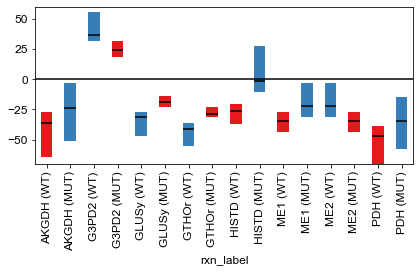

In [409]:

ax = plot_data.plot(kind='bar', y='Height', x='rxn_label', bottom=plot_data['min_drive'],
             color=plot_data['color'], legend=False)

translation = 0.25
for idx, row in plot_data.iterrows():
    plt.hlines(y=row.drive,xmax=idx+translation,xmin=idx-translation,color='k')

ax.axhline(0, color='black')
plt.ylim([-70,60])
plt.tight_layout()
#plt.show()
plt.savefig('freeEnergyRanges.rxn.MetaboliteConcentrations.svg')


In [340]:
plot_data

,rxn,gene,wt-coenzyme,coenzyme,min_drive,max_drive,drive,Height,color,wt,rxn_label
0,AKGDH,lpd,NAD,NAD,-31.391110,-60.534586,-36.107476,-29.143476,"(0.8941176470588236, 0.10196078431372549, 0.10...",True,AKGDH (WT)
1,AKGDH,lpd,NAD,NADP,-7.163772,-47.632519,-23.607803,-40.468747,"(0.21568627450980393, 0.49411764705882355, 0.7...",False,AKGDH (MUT)
2,G3PD2,gpsA,NADP,NADP,54.734482,32.344814,36.647658,-22.389667,"(0.21568627450980393, 0.49411764705882355, 0.7...",True,G3PD2 (WT)
3,G3PD2,gpsA,NADP,NAD,30.507143,19.442747,24.147985,-11.064397,"(0.8941176470588236, 0.10196078431372549, 0.10...",False,G3PD2 (MUT)
4,GLUSy,gltD,NADP,NADP,-27.893220,-46.221503,-31.098749,-18.328282,"(0.21568627450980393, 0.49411764705882355, 0.7...",True,GLUSy (WT)
5,GLUSy,gltD,NADP,NAD,-14.991153,-21.994164,-18.599075,-7.003011,"(0.8941176470588236, 0.10196078431372549, 0.10...",False,GLUSy (MUT)
6,GTHOr,gor,NADP,NADP,-37.069336,-54.302385,-40.972236,-17.233049,"(0.21568627450980393, 0.49411764705882355, 0.7...",True,GTHOr (WT)
7,GTHOr,gor,NADP,NAD,-24.167268,-30.075047,-28.472562,-5.907778,"(0.8941176470588236, 0.10196078431372549, 0.10...",False,GTHOr (MUT)
8,HISTD,hisD,NAD,NAD,-22.908686,-34.527347,-26.591443,-11.618661,"(0.8941176470588236, 0.10196078431372549, 0.10...",True,HISTD (WT)
9,HISTD,hisD,NAD,NADP,25.545990,-8.723212,-1.592096,-34.269203,"(0.21568627450980393, 0.49411764705882355, 0.7...",False,HISTD (MUT)


In [410]:
gene_synthesis = pd.read_csv('/Users/joshuagoldford/Documents/work/research_projects/coenzyme_redundancy/datasets/ribosome_profiling/table_S1.csv')
gene_synthesis = gene_synthesis.set_index('Gene')[['MOPS complete','MOPS minimal']]
gene_synthesis  = gene_synthesis.applymap(lambda x: np.float(str(x).replace('[','').replace(']','')))
gene_synthesis = gene_synthesis.apply(lambda x: x/x.sum())

<ipython-input-410-ca6a7f7149ae>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gene_synthesis  = gene_synthesis.applymap(lambda x: np.float(str(x).replace('[','').replace(']','')))


In [411]:
g = plot_data.set_index('gene').join(gene_synthesis)

In [412]:
g['protein_cost_mulitplier'] = g['drive'].apply(lambda x: rxn_quote(-abs(x)))

In [414]:
g['min_drive'].apply(lambda x: rxn_quote(-abs(x)))

gltD    1.000038
gltD    1.006959
gor     1.000001
gor     1.000161
gpsA    1.000000
gpsA    1.000007
hisD    1.000481
hisD    1.000027
lpd     1.000030
lpd     1.726936
lpd     1.000000
lpd     1.005014
maeA    1.000035
maeA    1.868404
maeB    1.880313
maeB    1.000035
Name: min_drive, dtype: float64

,rxn,wt-coenzyme,coenzyme,min_drive,max_drive,drive,Height,color,wt,rxn_label,MOPS complete,MOPS minimal,protein_cost_mulitplier
gltD,GLUSy,NADP,NADP,-26.949548,-47.165175,-31.098749,-20.215627,"(0.21568627450980393, 0.49411764705882355, 0.7...",True,GLUSy (WT),0.000071,0.001080,1.000007
gltD,GLUSy,NADP,NAD,-14.047481,-22.937836,-18.599075,-8.890356,"(0.8941176470588236, 0.10196078431372549, 0.10...",False,GLUSy (MUT),0.000071,0.001080,1.001107
gor,GTHOr,NADP,NADP,-36.285393,-55.086327,-40.972236,-18.800934,"(0.21568627450980393, 0.49411764705882355, 0.7...",True,GTHOr (WT),0.000180,0.000187,1.000000
gor,GTHOr,NADP,NAD,-23.383326,-30.858989,-28.472562,-7.475663,"(0.8941176470588236, 0.10196078431372549, 0.10...",False,GTHOr (MUT),0.000180,0.000187,1.000021
gpsA,G3PD2,NADP,NADP,55.539833,31.539463,36.647658,-24.000370,"(0.21568627450980393, 0.49411764705882355, 0.7...",True,G3PD2 (WT),0.000081,0.000063,1.000001
gpsA,G3PD2,NADP,NAD,31.312494,18.637396,24.147985,-12.675099,"(0.8941176470588236, 0.10196078431372549, 0.10...",False,G3PD2 (MUT),0.000081,0.000063,1.000118
hisD,HISTD,NAD,NAD,-20.667098,-36.768935,-26.591443,-16.101838,"(0.8941176470588236, 0.10196078431372549, 0.10...",True,HISTD (WT),0.000079,0.000240,1.000044
hisD,HISTD,NAD,NADP,27.787579,-10.964801,-1.592096,-38.752379,"(0.21568627450980393, 0.49411764705882355, 0.7...",False,HISTD (MUT),0.000079,0.000240,3.221657
lpd,AKGDH,NAD,NAD,-27.506136,-64.419561,-36.107476,-36.913425,"(0.8941176470588236, 0.10196078431372549, 0.10...",True,AKGDH (WT),0.002486,0.001700,1.000001
lpd,AKGDH,NAD,NADP,-3.278798,-51.517493,-23.607803,-48.238696,"(0.21568627450980393, 0.49411764705882355, 0.7...",False,AKGDH (MUT),0.002486,0.001700,1.000147


In [327]:
np.exp(-1.592096/RT) / np.exp(-26.591443/RT)

23870.098714728414

In [332]:
rxn_quote = lambda G: (np.exp(-G/RT) + 1) / (np.exp(-G/RT) - 1)

In [334]:
rxn_quote(-26.591443)

1.000044094000799

In [335]:
rxn_quote(-1.592096)

3.2216579266257095

In [337]:
rxn_quote(-8.72) / rxn_quote(-26.591443)

1.0612016287579953

In [290]:
plot_data['drive'].values[0]

-36.107476222014

In [127]:
pd.DataFrame(met_s).reset_index().replace({'nad_c':'nadp_c','nadh_c':'nadph_c'}).set_index('index')[0]

index
akg_c      -1.0
coa_c      -1.0
nadp_c     -1.0
co2_c       1.0
nadph_c     1.0
succoa_c    1.0
Name: 0, dtype: float64

In [116]:
set(met_s.index.tolist())

{'akg_c', 'co2_c', 'coa_c', 'nad_c', 'nadh_c', 'succoa_c'}

In [120]:
set(['nad_c','nadh_c']).issubset(set(met_s.index.tolist()))

True